<a href="https://colab.research.google.com/github/Bipin-6751/Machine-Learning-Collection/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [3]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


In [4]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

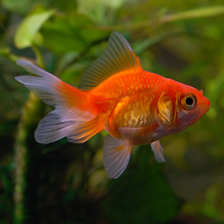

In [5]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [6]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [7]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [8]:
gold_fish[np.newaxis, ...].shape # it will add one more dimension, so that we can apply predict for one image

(1, 224, 224, 3)

In [9]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [10]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [11]:
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [12]:
image_labels[predicted_label_index]

'goldfish'

In [13]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228827136/228813984 [==============================] - 1s 0us/step


In [14]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [15]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/roses/1667199972_7ba7d999c1_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5249439791_196b4e7fc7.jpg'),
 PosixPath('datasets/flower_photos/roses/9320934277_4fb95aef5d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/1775233884_12ff5a124f.jpg'),
 PosixPath('datasets/flower_photos/roses/6363976189_e7155e5f9c.jpg')]

In [16]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [17]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/1667199972_7ba7d999c1_m.jpg'),
 PosixPath('datasets/flower_photos/roses/5249439791_196b4e7fc7.jpg'),
 PosixPath('datasets/flower_photos/roses/9320934277_4fb95aef5d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/1775233884_12ff5a124f.jpg'),
 PosixPath('datasets/flower_photos/roses/6363976189_e7155e5f9c.jpg')]

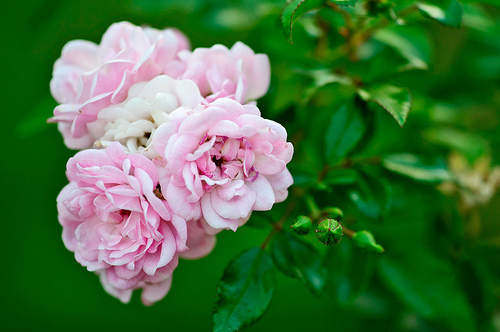

In [18]:
import PIL
PIL.Image.open(str(roses[1]))

In [19]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [20]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [21]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [22]:
img.shape

(240, 180, 3)

In [23]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [24]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [25]:
X = np.array(X)
y = np.array(y)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [27]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [28]:
X_train_scaled[0].shape

(224, 224, 3)

In [29]:
X[0].shape

(224, 224, 3)

In [30]:
predicted = classifier.predict(np.array([X[0], X[1], X[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 722, 412])

In [31]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [32]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 71s 791ms/step - loss: 0.7801 - acc: 0.7097
Epoch 2/5
86/86 [==============================] - 70s 810ms/step - loss: 0.4167 - acc: 0.8623
Epoch 3/5
86/86 [==============================] - 67s 783ms/step - loss: 0.3168 - acc: 0.8975
Epoch 4/5
86/86 [==============================] - 67s 784ms/step - loss: 0.2675 - acc: 0.9150
Epoch 5/5
86/86 [==============================] - 71s 831ms/step - loss: 0.2300 - acc: 0.9335


In [34]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 23s 775ms/step - loss: 0.3782 - acc: 0.8693


[0.3781821131706238, 0.8692810535430908]